In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 드라이브 내 위치로 이동
%cd /content/drive/MyDrive
!unzip FedAvg-Pytorch-main.zip
%cd FedAvg-Pytorch-main

/content/drive/MyDrive
Archive:  FedAvg-Pytorch-main.zip
fb62f4b8b99f9f3e7ad826d5fd7184fa26b5f82c
replace FedAvg-Pytorch-main/Fed_Avg.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Fed_Avg.ipynb  
replace FedAvg-Pytorch-main/Plots/IID.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Plots/IID.png  
replace FedAvg-Pytorch-main/Plots/Non-IID.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Plots/Non-IID.png  
replace FedAvg-Pytorch-main/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/README.md  
replace FedAvg-Pytorch-main/data.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/data.py  
y
y
y
replace FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m10.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m10.npy  
replace FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m50.npy? [y]es, [n]o, [A

In [4]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [12]:
# setting random seeds
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

In [13]:
# hyperparams
bsz = 10

In [14]:
# setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are currently using this device:", device)

We are currently using this device: cuda


60000


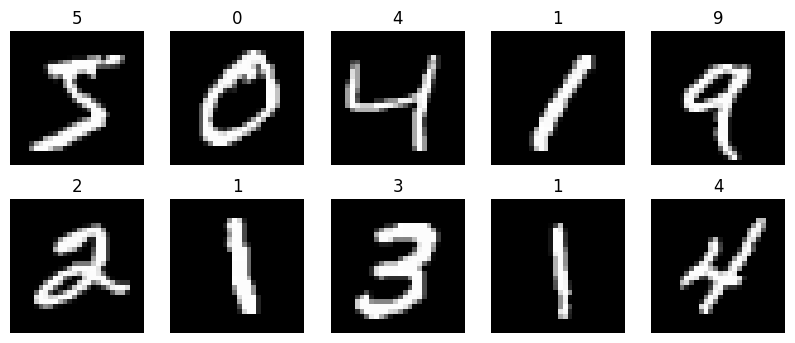

In [15]:
train_data, test_data = fetch_dataset()
print(len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [16]:
  # get client dataloaders
  iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)


iid:  tensor([54., 70., 55., 48., 60., 52., 64., 69., 60., 68.])


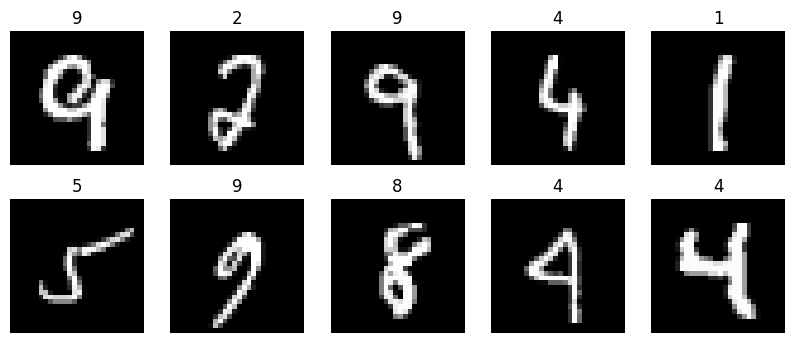

In [17]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([  0.,   0., 600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])


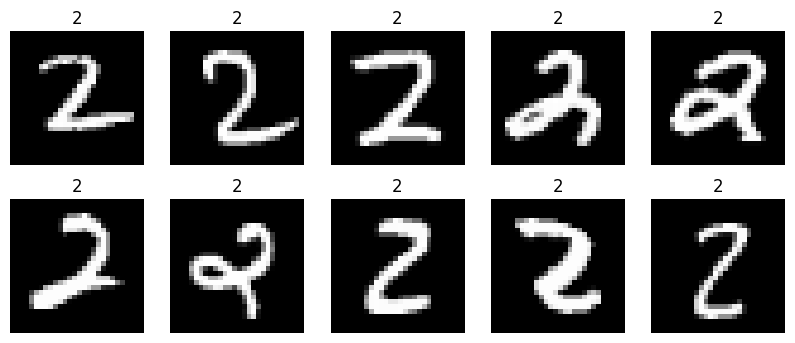

In [18]:
# non-iid
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[10]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

In [19]:
def num_params(model):
    """ """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [20]:
# define cnn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.out(x), dim=1)
        return x

def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = CNN()
print(model)
print("Total params:", num_params(model))


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
Total params: 1663370


In [13]:
## Training

In [21]:
criterion = nn.CrossEntropyLoss()
def validate(model):
    model = model.to(cuda)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(cuda)
            y = y.to(cuda)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [22]:
criterion = nn.CrossEntropyLoss()
def validate(model):
    model = model.to(device) # Use the correct device variable
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(device) # Use the correct device variable
            y = y.to(device) # Use the correct device variable
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device) # Use the correct device variable
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device) # Use the correct device variable
            y = y.to(device) # Use the correct device variable
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []

    # ---------------------
    # 워밍업 + 스케줄링 설정
    warmup_rounds = 10  # 처음 10라운드 동안 학습률 점진 증가
    min_lr = lr * 0.1   # 후반에 줄어드는 최소 학습률
    # ---------------------

    for t in range(max_rounds):
        # ---- 학습률 계산 ----
        if t < warmup_rounds:
            current_lr = lr * (t + 1) / warmup_rounds  # 선형 증가
        else:
            # Cosine annealing으로 서서히 감소
            progress = (t - warmup_rounds) / (max_rounds - warmup_rounds)
            current_lr = min_lr + 0.5 * (lr - min_lr) * (1 + np.cos(np.pi * progress))
        # --------------------

        print(f"starting round {t}, lr={current_lr:.5f}")

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace=False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i, c in enumerate(clients):
            print(f"round {t}, starting client {i+1}/{num_clients_per_round}, id: {c}")
            # train_client에 current_lr 전달
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, current_lr)

            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)

        global_model.load_state_dict(running_avg)

        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
            np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)

In [23]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))
cpu = torch.device('cpu')
cuda = torch.device('cuda')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
total params:  1663370


In [17]:
# CNN - iid - E-1, B=10 experiment
cpu='cpu'
cuda='cuda'
cnn_iid_e1b10 = copy.deepcopy(cnn)
acc_cnn_iid_e1b10 = fed_avg_experiment(cnn_iid_e1b10, num_clients_per_round=10,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_iid_e1b10')
print(acc_cnn_iid_e1b10)
np.save('./acc_cnn_iid_e1b10.npy', acc_cnn_iid_e1b10)


starting round 0, lr=0.00500
clients:  [19 14 43 37 66  3 79 41 38 68]
round 0, starting client 1/10, id: 19
round 0, starting client 2/10, id: 14
round 0, starting client 3/10, id: 43
round 0, starting client 4/10, id: 37
round 0, starting client 5/10, id: 66
round 0, starting client 6/10, id: 3
round 0, starting client 7/10, id: 79
round 0, starting client 8/10, id: 41
round 0, starting client 9/10, id: 38
round 0, starting client 10/10, id: 68
round 0, validation acc: 0.0987
starting round 1, lr=0.01000
clients:  [34 35 46 36 63 78 82 60 56 61]
round 1, starting client 1/10, id: 34
round 1, starting client 2/10, id: 35
round 1, starting client 3/10, id: 46
round 1, starting client 4/10, id: 36
round 1, starting client 5/10, id: 63
round 1, starting client 6/10, id: 78
round 1, starting client 7/10, id: 82
round 1, starting client 8/10, id: 60
round 1, starting client 9/10, id: 56
round 1, starting client 10/10, id: 61
round 1, validation acc: 0.0984
starting round 2, lr=0.01500
clie

In [18]:
# 데이터 로더 다시 만들기 (bsz=50)
iid_client_train_loader_b50 = iid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_iid_e1b50 = copy.deepcopy(cnn)

# 실험
acc_cnn_iid_e1b50 = fed_avg_experiment(
    cnn_iid_e1b50,
    num_clients_per_round=10,              # m=10
    num_local_epochs=1,                    # E=1
    lr=0.05,
    client_train_loader=iid_client_train_loader_b50,  # bsz=50 설정된 데이터로더
    max_rounds=300,
    filename='./acc_cnn_iid_e1b50'
)

# 결과 출력 및 저장
print(acc_cnn_iid_e1b50)
np.save('./acc_cnn_iid_e1b50.npy', acc_cnn_iid_e1b50)


starting round 0, lr=0.00500
clients:  [92 99 41 40 98 39 15 20 37 12]
round 0, starting client 1/10, id: 92
round 0, starting client 2/10, id: 99
round 0, starting client 3/10, id: 41
round 0, starting client 4/10, id: 40
round 0, starting client 5/10, id: 98
round 0, starting client 6/10, id: 39
round 0, starting client 7/10, id: 15
round 0, starting client 8/10, id: 20
round 0, starting client 9/10, id: 37
round 0, starting client 10/10, id: 12
round 0, validation acc: 0.0985
starting round 1, lr=0.01000
clients:  [79 88 97 55  2 96  5 82 93 77]
round 1, starting client 1/10, id: 79
round 1, starting client 2/10, id: 88
round 1, starting client 3/10, id: 97
round 1, starting client 4/10, id: 55
round 1, starting client 5/10, id: 2
round 1, starting client 6/10, id: 96
round 1, starting client 7/10, id: 5
round 1, starting client 8/10, id: 82
round 1, starting client 9/10, id: 93
round 1, starting client 10/10, id: 77
round 1, validation acc: 0.0986
starting round 2, lr=0.01500
clien

In [19]:
# CNN - non-iid - E=1,B=10 experiment
cnn_noniid_e1b10 = copy.deepcopy(cnn)
acc_cnn_noniid_e1b10 = fed_avg_experiment(cnn_noniid_e1b10, num_clients_per_round=10,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename = './acc_cnn_noniid_e1b10')
print(acc_cnn_noniid_e1b10)
np.save('./acc_cnn_noniid_e1b10.npy', acc_cnn_noniid_e1b10)


starting round 0, lr=0.00500
clients:  [97 63 26 37 22 52 40 96  7  6]
round 0, starting client 1/10, id: 97
round 0, starting client 2/10, id: 63
round 0, starting client 3/10, id: 26
round 0, starting client 4/10, id: 37
round 0, starting client 5/10, id: 22
round 0, starting client 6/10, id: 52
round 0, starting client 7/10, id: 40
round 0, starting client 8/10, id: 96
round 0, starting client 9/10, id: 7
round 0, starting client 10/10, id: 6
round 0, validation acc: 0.099
starting round 1, lr=0.01000
clients:  [25 54 33 45  4 53  0 44 75 64]
round 1, starting client 1/10, id: 25
round 1, starting client 2/10, id: 54
round 1, starting client 3/10, id: 33
round 1, starting client 4/10, id: 45
round 1, starting client 5/10, id: 4
round 1, starting client 6/10, id: 53
round 1, starting client 7/10, id: 0
round 1, starting client 8/10, id: 44
round 1, starting client 9/10, id: 75
round 1, starting client 10/10, id: 64
round 1, validation acc: 0.098
starting round 2, lr=0.01500
clients: 

In [20]:
# DataLoader 다시 생성: B = 50
noniid_loader_b50 = noniid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_noniid_e1b50 = copy.deepcopy(cnn)

# 실험 수행
acc_cnn_noniid_e1b50 = fed_avg_experiment(
    cnn_noniid_e1b50,
    num_clients_per_round=10,                  # m=10
    num_local_epochs=1,                        # E=1
    lr=0.05,
    client_train_loader=noniid_loader_b50,     # B=50, non-IID
    max_rounds=300,
    filename='./acc_cnn_noniid_e1b50'
)

# 결과 출력 및 저장
print(acc_cnn_noniid_e1b50)
np.save('./acc_cnn_noniid_e1b50.npy', acc_cnn_noniid_e1b50)


starting round 0, lr=0.00500
clients:  [54 64 44 31 50 23  9 93 26 40]
round 0, starting client 1/10, id: 54
round 0, starting client 2/10, id: 64
round 0, starting client 3/10, id: 44
round 0, starting client 4/10, id: 31
round 0, starting client 5/10, id: 50
round 0, starting client 6/10, id: 23
round 0, starting client 7/10, id: 9
round 0, starting client 8/10, id: 93
round 0, starting client 9/10, id: 26
round 0, starting client 10/10, id: 40
round 0, validation acc: 0.0974
starting round 1, lr=0.01000
clients:  [76 54 48 99 88 42  3  4 32 61]
round 1, starting client 1/10, id: 76
round 1, starting client 2/10, id: 54
round 1, starting client 3/10, id: 48
round 1, starting client 4/10, id: 99
round 1, starting client 5/10, id: 88
round 1, starting client 6/10, id: 42
round 1, starting client 7/10, id: 3
round 1, starting client 8/10, id: 4
round 1, starting client 9/10, id: 32
round 1, starting client 10/10, id: 61
round 1, validation acc: 0.1059
starting round 2, lr=0.01500
client

In [21]:
# CNN - iid -
cnn_iid_e5b10 = copy.deepcopy(cnn)
acc_cnn_iid_e5b10 = fed_avg_experiment(cnn_iid_e5b10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_iid_e5b10')



starting round 0, lr=0.00500
clients:  [91 33 76 64 30 87 84  1  5 94]
round 0, starting client 1/10, id: 91
round 0, starting client 2/10, id: 33
round 0, starting client 3/10, id: 76
round 0, starting client 4/10, id: 64
round 0, starting client 5/10, id: 30
round 0, starting client 6/10, id: 87
round 0, starting client 7/10, id: 84
round 0, starting client 8/10, id: 1
round 0, starting client 9/10, id: 5
round 0, starting client 10/10, id: 94
round 0, validation acc: 0.1002
starting round 1, lr=0.01000
clients:  [78 88 85 37 66 58 63 29 57 82]
round 1, starting client 1/10, id: 78
round 1, starting client 2/10, id: 88
round 1, starting client 3/10, id: 85
round 1, starting client 4/10, id: 37
round 1, starting client 5/10, id: 66
round 1, starting client 6/10, id: 58
round 1, starting client 7/10, id: 63
round 1, starting client 8/10, id: 29
round 1, starting client 9/10, id: 57
round 1, starting client 10/10, id: 82
round 1, validation acc: 0.1173
starting round 2, lr=0.01500
clien

In [22]:
print(acc_cnn_iid_e5b10)
np.save('./acc_cnn_iid_e5b10.npy', acc_cnn_iid_e5b10)

[0.1002 0.1173 0.7071 0.8195 0.9177 0.9349 0.9458 0.9532 0.9593 0.9615
 0.9653 0.9687 0.9701 0.9717 0.9724 0.9737 0.9756 0.9759 0.9774 0.9779
 0.979  0.98   0.9798 0.9795 0.9814 0.9818 0.982  0.982  0.9815 0.9828
 0.9828 0.983  0.9825 0.984  0.9836 0.9826 0.9842 0.9838 0.9846 0.9839
 0.9855 0.9847 0.9848 0.9853 0.9853 0.9859 0.986  0.9861 0.986  0.9866
 0.9872 0.9867 0.9875 0.987  0.9869 0.9878 0.9879 0.9878 0.9878 0.9876
 0.9878 0.988  0.9885 0.9887 0.9878 0.988  0.9886 0.9878 0.9885 0.9882
 0.9887 0.9891 0.9897 0.9893 0.9898 0.9888 0.9897 0.9887 0.9891 0.9897
 0.9902 0.9898 0.9905 0.9908 0.9906 0.9909 0.9901 0.9904 0.9899 0.9905
 0.99   0.9898 0.99   0.9907 0.9902 0.9908 0.99   0.9912 0.9902 0.9901
 0.9904 0.9904 0.9902 0.9906 0.9908 0.9908 0.9908 0.9904 0.991  0.9906
 0.9908 0.9904 0.9901 0.9901 0.9906 0.9911 0.9904 0.9905 0.9902 0.9905
 0.9911 0.991  0.991  0.991  0.9908 0.9908 0.9905 0.9906 0.9908 0.9911
 0.9909 0.9911 0.9907 0.9913 0.9913 0.9907 0.9913 0.991  0.9902 0.9906
 0.991

In [23]:
# DataLoader 다시 생성: B=50
iid_loader_b50 = iid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_iid_e5b50 = copy.deepcopy(cnn)

# 실험 실행
acc_cnn_iid_e5b50 = fed_avg_experiment(
    cnn_iid_e5b50,
    num_clients_per_round=10,                # m=10
    num_local_epochs=5,                      # E=5
    lr=0.05,
    client_train_loader=iid_loader_b50,      # B=50, IID
    max_rounds=300,
    filename='./acc_cnn_iid_e5b50'
)

# 결과 저장
print(acc_cnn_iid_e5b50)
np.save('./acc_cnn_iid_e5b50.npy', acc_cnn_iid_e5b50)


starting round 0, lr=0.00500
clients:  [12 99 56 69 73 72  8 16 71 20]
round 0, starting client 1/10, id: 12
round 0, starting client 2/10, id: 99
round 0, starting client 3/10, id: 56
round 0, starting client 4/10, id: 69
round 0, starting client 5/10, id: 73
round 0, starting client 6/10, id: 72
round 0, starting client 7/10, id: 8
round 0, starting client 8/10, id: 16
round 0, starting client 9/10, id: 71
round 0, starting client 10/10, id: 20
round 0, validation acc: 0.0987
starting round 1, lr=0.01000
clients:  [45 12 95 83 58 96 29 10 74 30]
round 1, starting client 1/10, id: 45
round 1, starting client 2/10, id: 12
round 1, starting client 3/10, id: 95
round 1, starting client 4/10, id: 83
round 1, starting client 5/10, id: 58
round 1, starting client 6/10, id: 96
round 1, starting client 7/10, id: 29
round 1, starting client 8/10, id: 10
round 1, starting client 9/10, id: 74
round 1, starting client 10/10, id: 30
round 1, validation acc: 0.0985
starting round 2, lr=0.01500
clie

In [24]:
# CNN - non-iid - E=5,B=10 experiment
cnn_noniid_e5b10 = copy.deepcopy(cnn)
acc_cnn_noniid_e5b10 = fed_avg_experiment(cnn_noniid_e5b10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_noniid_e5b10')
print(acc_cnn_noniid_e5b10)
np.save('./acc_cnn_noniid_e5b10.npy', acc_cnn_noniid_e5b10)


starting round 0, lr=0.00500
clients:  [ 9 76 30 83 71 86  6 27 48 34]
round 0, starting client 1/10, id: 9
round 0, starting client 2/10, id: 76
round 0, starting client 3/10, id: 30
round 0, starting client 4/10, id: 83
round 0, starting client 5/10, id: 71
round 0, starting client 6/10, id: 86
round 0, starting client 7/10, id: 6
round 0, starting client 8/10, id: 27
round 0, starting client 9/10, id: 48
round 0, starting client 10/10, id: 34
round 0, validation acc: 0.0973
starting round 1, lr=0.01000
clients:  [15 81 29 80  9 92 41 20 32 59]
round 1, starting client 1/10, id: 15
round 1, starting client 2/10, id: 81
round 1, starting client 3/10, id: 29
round 1, starting client 4/10, id: 80
round 1, starting client 5/10, id: 9
round 1, starting client 6/10, id: 92
round 1, starting client 7/10, id: 41
round 1, starting client 8/10, id: 20
round 1, starting client 9/10, id: 32
round 1, starting client 10/10, id: 59
round 1, validation acc: 0.4074
starting round 2, lr=0.01500
client

In [25]:
# DataLoader 다시 생성: B=50, non-IID
noniid_loader_b50 = noniid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_noniid_e5b50 = copy.deepcopy(cnn)

# 실험 실행
acc_cnn_noniid_e5b50 = fed_avg_experiment(
    cnn_noniid_e5b50,
    num_clients_per_round=10,                 # m=10
    num_local_epochs=5,                       # E=5
    lr=0.05,
    client_train_loader=noniid_loader_b50,    # B=50, non-IID
    max_rounds=300,
    filename='./acc_cnn_noniid_e5b50'
)

# 결과 저장
print(acc_cnn_noniid_e5b50)
np.save('./acc_cnn_noniid_e5b50.npy', acc_cnn_noniid_e5b50)



starting round 0, lr=0.00500
clients:  [40 55 81 73 30 69 70 67 14 97]
round 0, starting client 1/10, id: 40
round 0, starting client 2/10, id: 55
round 0, starting client 3/10, id: 81
round 0, starting client 4/10, id: 73
round 0, starting client 5/10, id: 30
round 0, starting client 6/10, id: 69
round 0, starting client 7/10, id: 70
round 0, starting client 8/10, id: 67
round 0, starting client 9/10, id: 14
round 0, starting client 10/10, id: 97
round 0, validation acc: 0.098
starting round 1, lr=0.01000
clients:  [94 82 81  9 42 75 54 90 89 52]
round 1, starting client 1/10, id: 94
round 1, starting client 2/10, id: 82
round 1, starting client 3/10, id: 81
round 1, starting client 4/10, id: 9
round 1, starting client 5/10, id: 42
round 1, starting client 6/10, id: 75
round 1, starting client 7/10, id: 54
round 1, starting client 8/10, id: 90
round 1, starting client 9/10, id: 89
round 1, starting client 10/10, id: 52
round 1, validation acc: 0.1426
starting round 2, lr=0.01500
clien

In [24]:
# B=∞ : 각 클라이언트 데이터 전부 한 배치로 로더 생성
iid_client_train_loader_binf = iid_partition_loader(train_data, bsz=len(train_data)//100)
noniid_client_train_loader_binf = noniid_partition_loader(train_data, bsz=len(train_data)//100)


In [36]:
cnn_iid_e1binf = copy.deepcopy(cnn)
acc_cnn_iid_e1binf = fed_avg_experiment(
    cnn_iid_e1binf,
    num_clients_per_round=10,
    num_local_epochs=1,
    lr=0.2,
    client_train_loader=iid_client_train_loader_binf,
    max_rounds=300,
    filename='./acc_cnn_iid_e1binf'
)
np.save('./acc_cnn_iid_e1binf.npy', acc_cnn_iid_e1binf)


starting round 0, lr=0.02000
clients:  [91 33 76 64 30 87 84  1  5 94]
round 0, starting client 1/10, id: 91
round 0, starting client 2/10, id: 33
round 0, starting client 3/10, id: 76
round 0, starting client 4/10, id: 64
round 0, starting client 5/10, id: 30
round 0, starting client 6/10, id: 87
round 0, starting client 7/10, id: 84
round 0, starting client 8/10, id: 1
round 0, starting client 9/10, id: 5
round 0, starting client 10/10, id: 94
round 0, validation acc: 0.0983
starting round 1, lr=0.04000
clients:  [78 88 85 37 66 58 63 29 57 82]
round 1, starting client 1/10, id: 78
round 1, starting client 2/10, id: 88
round 1, starting client 3/10, id: 85
round 1, starting client 4/10, id: 37
round 1, starting client 5/10, id: 66
round 1, starting client 6/10, id: 58
round 1, starting client 7/10, id: 63
round 1, starting client 8/10, id: 29
round 1, starting client 9/10, id: 57
round 1, starting client 10/10, id: 82
round 1, validation acc: 0.0985
starting round 2, lr=0.06000
clien

In [26]:
cnn_iid_e5binf = copy.deepcopy(cnn)
acc_cnn_iid_e5binf = fed_avg_experiment(
    cnn_iid_e5binf,
    num_clients_per_round=10,
    num_local_epochs=5,
    lr=0.5,
    client_train_loader=iid_client_train_loader_binf,
    max_rounds=300,
    filename='./acc_cnn_iid_e5binf'
)
np.save('./acc_cnn_iid_e5binf.npy', acc_cnn_iid_e5binf)


starting round 0, lr=0.01500
clients:  [92 99 41 40 98 39 15 20 37 12]
round 0, starting client 1/10, id: 92
round 0, starting client 2/10, id: 99
round 0, starting client 3/10, id: 41
round 0, starting client 4/10, id: 40
round 0, starting client 5/10, id: 98
round 0, starting client 6/10, id: 39
round 0, starting client 7/10, id: 15
round 0, starting client 8/10, id: 20
round 0, starting client 9/10, id: 37
round 0, starting client 10/10, id: 12
round 0, validation acc: 0.0985
starting round 1, lr=0.03000
clients:  [79 88 97 55  2 96  5 82 93 77]
round 1, starting client 1/10, id: 79
round 1, starting client 2/10, id: 88
round 1, starting client 3/10, id: 97
round 1, starting client 4/10, id: 55
round 1, starting client 5/10, id: 2
round 1, starting client 6/10, id: 96
round 1, starting client 7/10, id: 5
round 1, starting client 8/10, id: 82
round 1, starting client 9/10, id: 93
round 1, starting client 10/10, id: 77
round 1, validation acc: 0.0981
starting round 2, lr=0.04500
clien

In [27]:
cnn_noniid_e1binf = copy.deepcopy(cnn)
acc_cnn_noniid_e1binf = fed_avg_experiment(
    cnn_noniid_e1binf,
    num_clients_per_round=10,
    num_local_epochs=1,
    lr=0.1,
    client_train_loader=noniid_client_train_loader_binf,
    max_rounds=300,
    filename='./acc_cnn_noniid_e1binf'
)
np.save('./acc_cnn_noniid_e1binf.npy', acc_cnn_noniid_e1binf)


starting round 0, lr=0.01000
clients:  [97 63 26 37 22 52 40 96  7  6]
round 0, starting client 1/10, id: 97
round 0, starting client 2/10, id: 63
round 0, starting client 3/10, id: 26
round 0, starting client 4/10, id: 37
round 0, starting client 5/10, id: 22
round 0, starting client 6/10, id: 52
round 0, starting client 7/10, id: 40
round 0, starting client 8/10, id: 96
round 0, starting client 9/10, id: 7
round 0, starting client 10/10, id: 6
round 0, validation acc: 0.0981
starting round 1, lr=0.02000
clients:  [25 54 33 45  4 53  0 44 75 64]
round 1, starting client 1/10, id: 25
round 1, starting client 2/10, id: 54
round 1, starting client 3/10, id: 33
round 1, starting client 4/10, id: 45
round 1, starting client 5/10, id: 4
round 1, starting client 6/10, id: 53
round 1, starting client 7/10, id: 0
round 1, starting client 8/10, id: 44
round 1, starting client 9/10, id: 75
round 1, starting client 10/10, id: 64
round 1, validation acc: 0.098
starting round 2, lr=0.03000
clients:

In [28]:
cnn_noniid_e5binf = copy.deepcopy(cnn)
acc_cnn_noniid_e5binf = fed_avg_experiment(
    cnn_noniid_e5binf,
    num_clients_per_round=10,
    num_local_epochs=5,
    lr=0.1,
    client_train_loader=noniid_client_train_loader_binf,
    max_rounds=300,
    filename='./acc_cnn_noniid_e5binf'
)
np.save('./acc_cnn_noniid_e5binf.npy', acc_cnn_noniid_e5binf)


starting round 0, lr=0.01000
clients:  [54 64 44 31 50 23  9 93 26 40]
round 0, starting client 1/10, id: 54
round 0, starting client 2/10, id: 64
round 0, starting client 3/10, id: 44
round 0, starting client 4/10, id: 31
round 0, starting client 5/10, id: 50
round 0, starting client 6/10, id: 23
round 0, starting client 7/10, id: 9
round 0, starting client 8/10, id: 93
round 0, starting client 9/10, id: 26
round 0, starting client 10/10, id: 40
round 0, validation acc: 0.0964
starting round 1, lr=0.02000
clients:  [76 54 48 99 88 42  3  4 32 61]
round 1, starting client 1/10, id: 76
round 1, starting client 2/10, id: 54
round 1, starting client 3/10, id: 48
round 1, starting client 4/10, id: 99
round 1, starting client 5/10, id: 88
round 1, starting client 6/10, id: 42
round 1, starting client 7/10, id: 3
round 1, starting client 8/10, id: 4
round 1, starting client 9/10, id: 32
round 1, starting client 10/10, id: 61
round 1, validation acc: 0.1019
starting round 2, lr=0.03000
client

In [29]:
import numpy as np
import matplotlib.pyplot as plt
# acc-> accuracy mlp/cnn iid/non idd all vector fecthed and ploted

In [37]:
acc_cnn_iid_e1b10 = np.load('./acc_cnn_iid_e1b10.npy')
acc_cnn_iid_e1b50 = np.load('./acc_cnn_iid_e1b50.npy')
acc_cnn_iid_e5b10 = np.load('./acc_cnn_iid_e5b10.npy')
acc_cnn_iid_e5b50 = np.load('./acc_cnn_iid_e5b50.npy')
acc_cnn_iid_e1binf = np.load('./acc_cnn_iid_e1binf.npy')
acc_cnn_iid_e5binf = np.load('./acc_cnn_iid_e5binf.npy')

In [31]:
#non iid
acc_cnn_noniid_e1b10 = np.load('./acc_cnn_noniid_e1b10.npy')
acc_cnn_noniid_e1b50 = np.load('./acc_cnn_noniid_e1b50.npy')
acc_cnn_noniid_e5b10 = np.load('./acc_cnn_noniid_e5b10.npy')
acc_cnn_noniid_e5b50 = np.load('./acc_cnn_noniid_e5b50.npy')
acc_cnn_noniid_e1binf = np.load('./acc_cnn_noniid_e1binf.npy')
acc_cnn_noniid_e5binf = np.load('./acc_cnn_noniid_e5binf.npy')

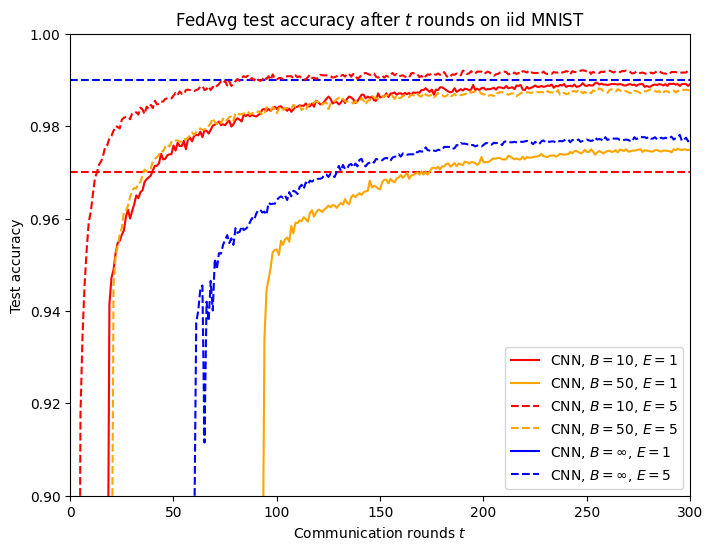

In [39]:
def moving_average(data, window_size=5):
    """단순 이동평균 스무딩"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# 스무딩 적용
acc_cnn_iid_e1b10_smooth = moving_average(acc_cnn_iid_e1b10, window_size=5)
acc_cnn_iid_e1b50_smooth = moving_average(acc_cnn_iid_e1b50, window_size=5)
acc_cnn_iid_e5b10_smooth = moving_average(acc_cnn_iid_e5b10, window_size=5)
acc_cnn_iid_e5b50_smooth = moving_average(acc_cnn_iid_e5b50, window_size=5)
acc_cnn_iid_e1binf_smooth = moving_average(acc_cnn_iid_e1binf, window_size=5)
acc_cnn_iid_e5binf_smooth = moving_average(acc_cnn_iid_e5binf, window_size=5)
x = np.arange(1,301)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 300, 0.90, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x[:300], acc_cnn_iid_e1b10, label='CNN, $B=10$, $E=1$', color = 'red')
plt.plot(x[:300],acc_cnn_iid_e1b50 , label='CNN, $B=50$, $E=1$', color = 'orange')
plt.plot(x[:300], acc_cnn_iid_e5b10, label='CNN, $B=10$, $E=5$',linestyle='dashed', color = 'red')
plt.plot(x[:300], acc_cnn_iid_e5b50, label='CNN, $B=50$, $E=5$',linestyle='dashed', color='orange')
plt.plot(x[:300], acc_cnn_iid_e1binf, label='CNN, $B=\infty$, $E=1$', color = 'blue')
plt.plot(x[:300], acc_cnn_iid_e5binf, label='CNN, $B=\infty$, $E=5$', linestyle='dashed', color = 'blue')
#plt.plot(np.arange(1,52), acc_cnn_iid_m50, label='CNN, $m=50$, $E=5$')

plt.legend()

plt.show()

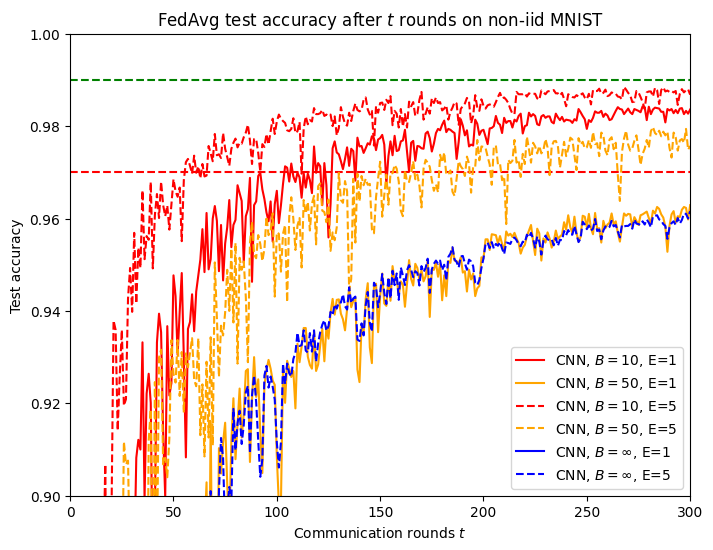

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    """단순 이동평균 스무딩"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# 스무딩 적용
acc_cnn_noniid_e1b10_smooth = moving_average(acc_cnn_noniid_e1b10, window_size=5)
acc_cnn_noniid_e1b50_smooth = moving_average(acc_cnn_noniid_e1b50, window_size=5)
acc_cnn_noniid_e5b10_smooth = moving_average(acc_cnn_noniid_e5b10, window_size=5)
acc_cnn_noniid_e5b50_smooth = moving_average(acc_cnn_noniid_e5b50, window_size=5)
acc_cnn_noniid_e1binf_smooth = moving_average(acc_cnn_noniid_e1binf, window_size=5)
acc_cnn_noniid_e5binf_smooth = moving_average(acc_cnn_noniid_e5binf, window_size=5)
x = np.arange(1,301)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on non-iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 300, 0.90, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='g', linestyle='dashed')
plt.plot(x, acc_cnn_noniid_e1b10, label='CNN, $B=10$, E=1',color = 'red')
plt.plot(x, acc_cnn_noniid_e1b50, label='CNN, $B=50$, E=1', color = 'orange')
plt.plot(x, acc_cnn_noniid_e5b10, label='CNN, $B=10$, E=5',linestyle='dashed',color = 'red')
plt.plot(x, acc_cnn_noniid_e5b50, label='CNN, $B=50$, E=5', linestyle='dashed',color = 'orange')
plt.plot(x, acc_cnn_noniid_e1binf, label='CNN, $B=\infty$, E=1', color = 'blue')
plt.plot(x, acc_cnn_noniid_e5binf, label = 'CNN, $B=\infty$, E=5',linestyle='dashed', color = 'blue')

plt.legend()
plt.show()